In [1]:
import pandas as pd
import numpy as np

# download chinook database tables
chinook_customers = pd.read_csv(
  "https://ona-book.org/data/chinook_customers.csv"
)
chinook_invoices = pd.read_csv(
  "https://ona-book.org/data/chinook_invoices.csv"
)
chinook_items = pd.read_csv(
  "https://ona-book.org/data/chinook_items.csv"
)

In [7]:
joined_tables = pd.merge(
  chinook_customers,
  chinook_invoices
)

joined_tables = pd.merge(joined_tables, chinook_items)

joined_tables['FullName'] = joined_tables['FirstName'] + ' ' + joined_tables['LastName']

cust_item_table = joined_tables[['FullName', 'TrackId']].drop_duplicates()
cust_item_table.head()

# trackid refers to each unique items

,FullName,TrackId
0,Luís Gonçalves,3247
1,Luís Gonçalves,3248
2,Luís Gonçalves,447
3,Luís Gonçalves,449
4,Luís Gonçalves,451


In [8]:
import networkx as nx
from matplotlib import pyplot as plt

# create networkx object
cust_item_network = nx.from_pandas_edgelist(cust_item_table,
source = "FullName", target = "TrackId")

In [10]:
# color items differently to customers
colors = ["red" if i in cust_item_table['FullName'].values else "green"
for i in cust_item_network.nodes]

Figure 4.7: Visualization of the Chinook customer-to-item network with customers as red vertices and items as green vertices

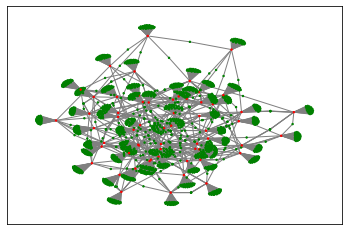

In [14]:
# visualize
np.random.seed(123)
nx.draw_networkx(cust_item_network, node_color = colors, node_size = 2,
edge_color = "grey", with_labels = False)
plt.show()

Next: customer-to-customer network based on common item purchases

In [15]:
# merge customers on common track IDs
cust_cust_table = pd.merge(cust_item_table, cust_item_table,
on = "TrackId")

In [17]:
# rename columns
cust_cust_table.rename(
  columns={'FullName_x' :'CustName1', 'FullName_y' :'CustName2'},
  inplace=True
)

In [18]:
# remove loop edges
cust_cust_table = cust_cust_table[
  ~(cust_cust_table['CustName1'] == cust_cust_table['CustName2'])
]

# view head
cust_cust_table.head()

,CustName1,TrackId,CustName2
4,Luís Gonçalves,449,Edward Francis
5,Edward Francis,449,Luís Gonçalves
11,Luís Gonçalves,1157,Richard Cunningham
12,Richard Cunningham,1157,Luís Gonçalves
17,Luís Gonçalves,1169,Richard Cunningham


In [21]:
# drop duplicates
cust_cust_table = cust_cust_table.drop_duplicates('TrackId')

# count common items
cust_cust_table = cust_cust_table.groupby(['CustName1', 'CustName2'], 
as_index = False).TrackId.nunique()
cust_cust_table.rename(columns = {'TrackId': 'Items'}, inplace = True)

# view head
cust_cust_table.head()

,CustName1,CustName2,Items
0,Aaron Mitchell,Enrique Muñoz,1
1,Aaron Mitchell,Hugh O'Reilly,1
2,Aaron Mitchell,Niklas Schröder,1
3,Aaron Mitchell,Phil Hughes,1
4,Alexandre Rocha,Aaron Mitchell,1


Figure 4.8: Visualization of the Chinook customer-to-customer network based on any common item purchase

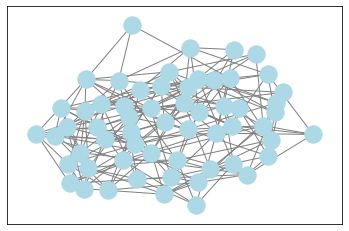

In [22]:
# create networkx object
cust_cust_network = nx.from_pandas_edgelist(cust_cust_table,
source = "CustName1", target = "CustName2", edge_attr = True)

# visualize
np.random.seed(3005)
nx.draw_networkx(cust_cust_network, node_color = "lightblue",
edge_color = "grey", with_labels = False)
plt.show()

Figure 4.9: Visualization of the Chinook customer-to-customer network based on at least two common item purchases

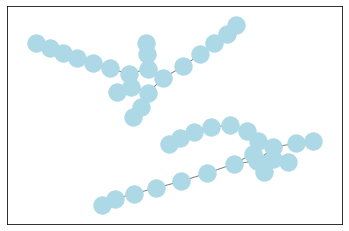

In [24]:
# get edges with items >= 2
twoitem_edges = [i for i in list(cust_cust_network.edges) if 
cust_cust_network.edges[i]['Items'] >= 2]

# create subgraph
twoitem_network = cust_cust_network.edge_subgraph(twoitem_edges) 

# visualize in FR (spring) layout
np.random.seed(123)
layout = nx.spring_layout(twoitem_network, k = 0.05)
nx.draw_networkx(twoitem_network, node_color = "lightblue",
edge_color = "grey", with_labels = False, pos = layout)
plt.show()

web scraping

In [25]:
import requests
from bs4 import BeautifulSoup

url = "https://fangj.github.io/friends/season/0101.html"
script = requests.get(url)

# parse the html of the page
friends_ep1 = BeautifulSoup(script.text, "html.parser")

In [43]:
originalString = "Scene:"
replaceString = "<b>New Scene:</b>"
friends_ep1_replace = BeautifulSoup(str(friends_ep1).replace(originalString, replaceString), "html.parser")

In [45]:
# use re (regular expressions) package
import re

# find everything in bold tags with alpha preceding a colon
searchstring = re.compile("^[A-Za-z ]+(?=:)")
friends_ep1_bold = friends_ep1_replace.find_all(['b', 'strong'], 
text = searchstring)

# extract the text and remove colons
friends_ep1_list = [friends_ep1_bold[i].text.replace(':', '') 
for i in range(0, len(friends_ep1_bold) - 1)]

# check first few unique values returned
sorted(set(friends_ep1_list))[0:7]

['All', 'Chandler', 'Chandler ', 'Customer', 'Frannie', 'Joey', 'Monica']

In [46]:
friends_ep1_list2=[entry.strip() 
for entry in friends_ep1_list 
if "All" not in entry and " and " not in entry]

# check first few entries
sorted(set(friends_ep1_list2))[0:7]

['Chandler', 'Customer', 'Frannie', 'Joey', 'Monica', 'New Scene', 'Paul']

organize our characters by scene

In [47]:
import pandas as pd

# number scene by counting previous "New Scene" entries and adding 1
scene_count = []

for i in range(0,len(friends_ep1_list2)):
  scene_count.append(friends_ep1_list2[0:i+1].count("New Scene"))
  
# create a pandas dataframe
df = {'scene': scene_count, 'character': friends_ep1_list2}
scenes_df = pd.DataFrame(df)

# remove New Scene rows
scenes_df = scenes_df[scenes_df.character != "New Scene"]

# get unique characters by scene
scenes = scenes_df.groupby('scene')['character'].unique()

# check
scenes.head()

scene
1    [Monica, Joey, Chandler, Phoebe, Ross, Rachel,...
2    [Monica, Chandler, Ross, Rachel, Phoebe, Joey,...
3                                             [Phoebe]
4                               [Ross, Joey, Chandler]
5                                       [Monica, Paul]
Name: character, dtype: object

In [48]:
# create a function to find all unique pairs inside a scene character list

import numpy as np 

# define function
def unique_pairs(chars: object) -> pd.DataFrame:
  # start with uniques
  characters = np.unique(chars)
  # create from-to list dataframe
  char1 = []
  char2 = []
  df = pd.DataFrame({'char1': char1, 'char2': char2})
  # iterate over each entry to form pairs
  if len(characters) > 1:
    for i in range(0, len(characters) - 1):
      char1 = [characters[i]] * (len(characters) - i - 1)
      char2 = [characters[i] for i in range(i + 1, len(characters))]
      # append to dataframe
      df2 = pd.DataFrame({'char1': char1, 'char2': char2})
      df = df.append(df2, ignore_index = True)
  return df

# test on scene 11
unique_pairs(scenes[11])

,char1,char2
0,Chandler,Joey
1,Chandler,Monica
2,Chandler,Paul
3,Chandler,Rachel
4,Joey,Monica
5,Joey,Paul
6,Joey,Rachel
7,Monica,Paul
8,Monica,Rachel
9,Paul,Rachel


In [51]:
# start DataFrame
char1 = []
char2 = []

edgelist_df = pd.DataFrame({'char1': char1, 'char2': char2})

for scene in scenes:
  df = unique_pairs(scene)
  edgelist_df = edgelist_df.append(df, ignore_index = True)

In [53]:
# sort each row alphabetically
edgelist_df = edgelist_df.sort_values(by = ['char1', 'char2'])

# count by unique pair
edgelist = edgelist_df.groupby(['char1', 'char2']).\
apply(len).to_frame("weight").reset_index()

# check
edgelist.head()

,char1,char2,weight
0,Chandler,Customer,1
1,Chandler,Joey,8
2,Chandler,Monica,6
3,Chandler,Paul,2
4,Chandler,Phoebe,5


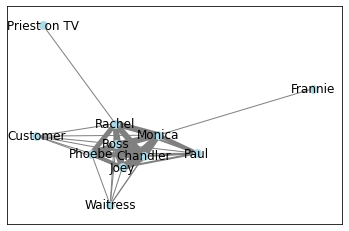

In [54]:
import networkx as nx
from matplotlib import pyplot as plt

# create networkx object
friends_ep1_network = nx.from_pandas_edgelist(edgelist,
source = "char1", target = "char2", edge_attr=True)

# visualize with edge weight as edge width
np.random.seed(123)
weights = list(
  nx.get_edge_attributes(friends_ep1_network, 'weight').values()
)
nx.draw_networkx(
  friends_ep1_network, node_color = "lightblue", node_size = 60,
  edge_color = "grey", with_labels = True, width = np.array(weights)
)
plt.show()
